In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load data for training and test splits into DataFrame
comments = pd.read_csv('attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations = pd.read_csv('attack_annotations.tsv', sep='\t')

In [3]:
# print the # of unique rev_id
print('There are', len(annotations['rev_id'].unique()), 'unique rev_id')

There are 115864 unique rev_id


In [4]:
# labels a comment as an attack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [5]:
# insert labels in comments
comments['attack'] = labels

In [6]:
# Parsing: remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))


In [7]:
# holdout external files for later ML predictions
politics_filename = 'politics_comments.json'
vgames_filename = 'Leagueoflegends_submissions.json'
soccer_filename = 'soccer_comments.json'

In [8]:
# POLITICS

with open(politics_filename, 'r') as pol_f:
    politics_dict = json.load(pol_f)

politics_df = pd.DataFrame(politics_dict)
politics_comments = politics_df['body']

In [9]:
# GAMES

with open(vgames_filename, 'r') as vgames_f:
    vgames_dict = json.load(vgames_f)

vgames_df = pd.DataFrame(vgames_dict)
vgames_comments = vgames_df['selftext']

In [10]:
# SOCCER

with open(soccer_filename, 'r') as soc_f:
    soccer_dict = json.load(soc_f)

soccer_df = pd.DataFrame(soccer_dict)
soccer_comments = soccer_df['body']

In [11]:
# Presentation

print('This is your DataFrame:\n')
print(comments.head())
print('These are the head of the comments classified as an attack\n')
print(comments.query('attack')['comment'].head())

This is your DataFrame:

                                                  comment  year  logged_in  \
rev_id                                                                       
37675   `- This is not ``creative``.  Those are the di...  2002      False   
44816   `  :: the term ``standard model`` is itself le...  2002      False   
49851     True or false, the situation as of March 200...  2002      False   
89320    Next, maybe you could work on being less cond...  2002       True   
93890                This page will need disambiguation.   2002       True   

             ns  sample  split  attack  
rev_id                                  
37675   article  random  train   False  
44816   article  random  train   False  
49851   article  random  train   False  
89320   article  random    dev   False  
93890   article  random  train   False  
These are the head of the comments classified as an attack

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      

In [12]:
# hold split

X_politics = politics_comments
X_vgames = vgames_comments
X_soccer = soccer_comments

In [13]:
# Defining X and y
X = comments['comment']
y = comments['attack']

In [14]:
# internal splits for training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.33, random_state=53)

In [15]:
# Setup the pipeline
steps = [('vec', CountVectorizer(analyzer='char', ngram_range=(1, 5), max_features=50000)),
         ('tfidf', TfidfTransformer(norm='l2', sublinear_tf=True)),
         ('clf', LogisticRegression(C=10))]

In [16]:
pipeline = Pipeline(steps)

In [17]:
# Fit to the training set (this is where the learning is; with X_train it learns the associated labels, y_train)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vec', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [18]:
# Predict the labels of the test set: y_pred
y_pred = pipeline.predict(X_test)

In [19]:
# Compute and print metrics
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
print('\n\n\n')
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9484778742546291




             precision    recall  f1-score   support

      False       0.96      0.98      0.97     33671
       True       0.85      0.69      0.76      4565

avg / total       0.95      0.95      0.95     38236



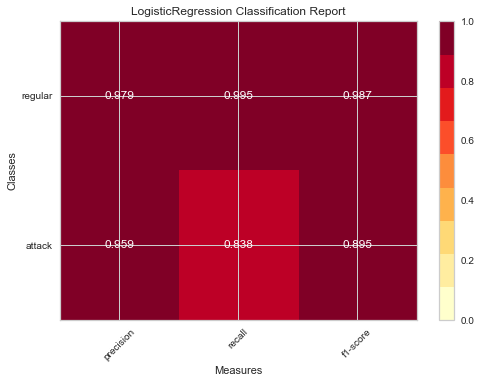

In [20]:
# Instantiate the classification model and visualizer with YellowBrick
visualizer = ClassificationReport(pipeline, classes=['regular', 'attack'])
visualizer.fit(X_train, y_train)
visualizer.score(X_train, y_train)
visualizer.poof()

# HOLDOUT OUTPUTS

## POLITICS from Reddit

In [21]:
print('POLITICS COMMENTS', '\n', '\n', '\n',)

pipeline.predict(X_politics)

politics_output = []

for text in X_politics:
    politics_output.append({'Comment': text, 'ML_Label': pipeline.predict([text])[0]})

politics_outcome = pd.DataFrame(politics_output)

politics_outcome.to_csv('politics_ML_evaluated.csv', index=False, header=False)

POLITICS COMMENTS 
 
 



In [22]:
print(politics_outcome.head)

<bound method NDFrame.head of                                                Comment  ML_Label
0    Flynn, Kushner, DT JR, sessions next for the c...     False
1    Has anyone listened to Preet Bharara's podcast...     False
2                               He's going to Jared.       False
3               Is he a rook or a knight on the board?     False
4    Here's the thing, the only person who can fire...     False
5    Papadapolous > Manafort > Flynn > Kushner > Se...     False
6    Everyone pay no attention to this nothingburge...     False
7    So then why isn't the GOP calling for his resi...     False
8    It's comforting to think that maybe, just mayb...     False
9                                            Haha yes.     False
10   Can't wait for Trump to say he barely knows hi...     False
11   [Maybe a tad bit excited.](http://fanaru.com/a...     False
12   Lmao whoever is responsible for firing Comey, ...      True
13   [This video is becoming prophecy.](https://www...     F

## VIDEOGAMES (League of Legends) from Reddit

In [23]:
print('VIDEOGAMES COMMENTS', '\n', '\n', '\n',)

pipeline.predict(X_vgames)

videogames_output = []

for text in X_vgames:
    videogames_output.append({'Comment': text, 'ML_Label': pipeline.predict([text])[0]})

videogames_outcome = pd.DataFrame(videogames_output)

videogames_outcome.to_csv('videogames_ML_evaluated.csv', index=False, header=False)

VIDEOGAMES COMMENTS 
 
 



In [24]:
print(videogames_outcome.head)

<bound method NDFrame.head of                                               Comment  ML_Label
0   I believe the main reason the borders of the e...     False
1   - The snowballing is even worse. Games are bas...     False
2   # Definitive Preseason Guide\n\nHello! Welcome...     False
3   I would like to request we remove the old CS m...     False
4   So let me get this straight, I have to play li...     False
5   I have dodged multiple times already and this ...     False
6   Hello,\n\n\n\nSo since a lot of people value t...     False
7   I had every single rune you can get. There is ...     False
8   I was supposed to receive something like 10000...     False
9                          We really missed you, bud.     False
10  Today i calculated the amount of total combina...     False
11  https://clips.twitch.tv/PrettyFlirtyAntTinyFac...     False
12  I'm not gunna argue with that stupid ass Jayce...      True
13  Kinda really disappointed to not see this yet....     False
14  Okay, 

## SOCCER from Reddit

In [25]:
print('SOCCER COMMENTS', '\n', '\n', '\n',)


pipeline.predict(X_soccer)

soccer_output = []

for text in X_soccer:
    soccer_output.append({'Comment': text, 'ML_Label': pipeline.predict([text])[0]})

soccer_outcome = pd.DataFrame(soccer_output)

soccer_outcome.to_csv('soccer_ML_evaluated.csv', index=False, header=False)

SOCCER COMMENTS 
 
 



In [26]:
print(soccer_outcome.head)

<bound method NDFrame.head of                                               Comment  ML_Label
0   "You're a fucking monkey.... quick lets jump a...      True
1   Why is it *always* Zenit I hear about this wit...     False
2   Think this will happen at the World Cup? Hones...     False
3   But comrade Stan Collymore said racism doesn't...     False
4   > DUELL: Zenits Emiliano Rigoni i duell med Sa...     False
5                    Give Rosenberg a 3-0 def win tbh     False
6                                             Classic     False
7   ''it won't be safe next summer in Russia'' obl...     False
8   Lol a few years ago Zenit had a total of zero ...     False
9   They’ve had none remotely close to the first t...     False
10  Zenit fans always say "In the colors of Zenith...     False
11  Yep, unfortunately. Makes me ashamed to be a Z...     False
12  Their ultras are pure, distilled scum. Look wh...     False
13                                    Yes definitely      False
14  Fuck n